In [1]:
import os
import pickle
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.sac import sac
from rlib.common.buffer import ReplayBuffer, RolloutBuffer
from rlib.common.evaluation import get_trajectory, save_frames_as_gif, validation
from rlib.common.logger import TensorBoardLogger
from rlib.common.policies import DeterministicMlpPolicy, MlpQCritic, StochasticMlpPolicy

%load_ext autoreload
%autoreload 2

In [4]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [5]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


### Expert

In [ ]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [ ]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=20_000,
)

In [ ]:
validation(env, actor)

-169.38176753538576

In [ ]:
with open("./models/pendulum_stoc_expert", "wb") as file:
    pickle.dump(actor, file)

### Expert Data

In [ ]:
with open("./models/pendulum_stoc_expert", "rb") as file:
    expert_actor = pickle.load(file)

In [ ]:
validation(env, expert_actor)

-147.11891162762515

In [ ]:
rb = RolloutBuffer()

In [ ]:
rb.collect_rollouts(env, expert_actor, trajectories_n=50)

In [ ]:
expert_trajectories = rb.get_data()

## GCL

### Train

In [26]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [27]:
class CustomNNRewardWrapper(gym.Wrapper):
    def __init__(self, env, reward_fn):
        super().__init__(env)
        self.reward_fn = reward_fn

    def step(self, action):
        """
        Args:
            action: (np.ndarray): (action_dim,)
        """
        observation, reward, terminated, truncated, info = self.env.step(action)

        observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
        action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

        reward_t = self.reward_fn(observation_t, action_t)
        reward = reward_t.item()

        return observation, reward, terminated, truncated, info


In [28]:
def gcl_loss(
    reward_net,
    learning_trajectories,
    expert_trajectories,
):
    loss = {}

    learning_observations = learning_trajectories["observations"]
    learning_actions = learning_trajectories["actions"]

    loss["learning_rewards"] = reward_net(learning_observations, learning_actions).sum()

    expert_observations = expert_trajectories["observations"]
    expert_actions = expert_trajectories["actions"]

    loss["expert_rewards"] = reward_net(expert_observations, expert_actions).sum()

    loss["reward"] = -(loss["expert_rewards"] - loss["learning_rewards"])

    return loss

In [33]:
def gcl(
    env: gym.Env,
    expert_trajectories: dict[str, torch.Tensor],
    learning_actor: DeterministicMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    reward_net: RewardNet,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    reward_optimizer: Adam,
    total_episodes: int = 30,
):
    rollout_buffer = RolloutBuffer()
    env = CustomNNRewardWrapper(env, reward_net)

    logger = TensorBoardLogger(log_dir="./tb_logs/gcl_")

    for episode_n in range(total_episodes):

        rollout_buffer.collect_rollouts(env, learning_actor, trajectories_n=50)
        learning_trajectories = rollout_buffer.get_data()

        loss = gcl_loss(reward_net, learning_trajectories, expert_trajectories)

        loss["reward"].backward()
        reward_optimizer.step()
        reward_optimizer.zero_grad()

        env = CustomNNRewardWrapper(env, reward_net)

        sac(
            env,
            learning_actor,
            critic_1,
            critic_2,
            actor_optimizer,
            critic_1_optimizer,
            critic_2_optimizer,
            total_timesteps=5000,
        )

        # Logging
        logger.log_scalars(loss, episode_n)

In [34]:
learning_actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

reward_net = RewardNet(obs_dim, action_dim)

actor_optimizer = Adam(learning_actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

reward_optimizer = Adam(reward_net.parameters(), lr=1e-4)

In [35]:
gcl(
    env,
    expert_trajectories,
    learning_actor,
    critic_1,
    critic_2,
    reward_net,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    reward_optimizer,
)

In [38]:
with open("./models/pendulum_nn_reward_2", "wb") as file:
    pickle.dump(reward_net, file)

### Visualisation

In [36]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [39]:
def original_reward(state, action):
    theta, theta_dot = state
    cost = theta**2 + 0.1 * theta_dot**2 + 0.001 * action**2
    return -cost

In [40]:
def nn_reward(state, action):
    theta, thetadot = state
    observation = np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
    action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

    reward_t = reward_net(observation_t, action_t)
    reward = reward_t.item()

    return reward

In [47]:
def plot_rewards(reward_fn):

    fig, axs = plt.subplots(ncols=3)

    theta_ls = np.linspace(-np.pi, np.pi)
    theta_dot_ls = np.linspace(-1, 1)
    action_ls = np.linspace(-1, 1)

    state = np.array([0, 0], dtype=np.float32)
    action = np.array(0)

    rewards = []
    for theta in theta_ls:
        state[0] = theta
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[0].plot(theta_ls, rewards)

    state = np.array([0, 0], dtype=np.float32)

    rewards = []
    for theta_dot in theta_dot_ls:
        state[1] = theta_dot
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[1].plot(theta_dot_ls, rewards)

    state = np.array([0, 0], dtype=np.float32)

    rewards = []
    for action in action_ls:
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[2].plot(action_ls, rewards)

    fig.tight_layout()

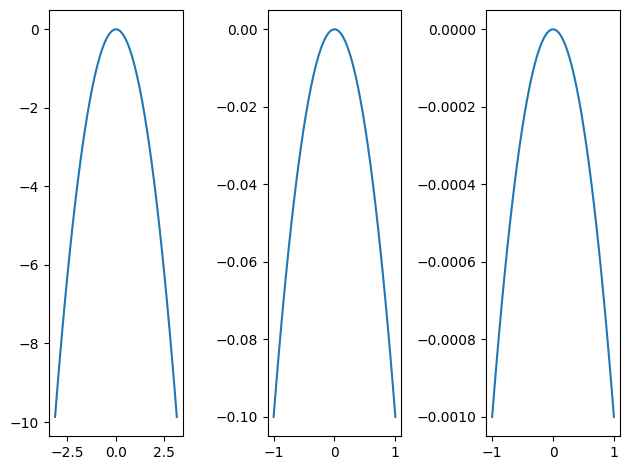

In [49]:
plot_rewards(original_reward)

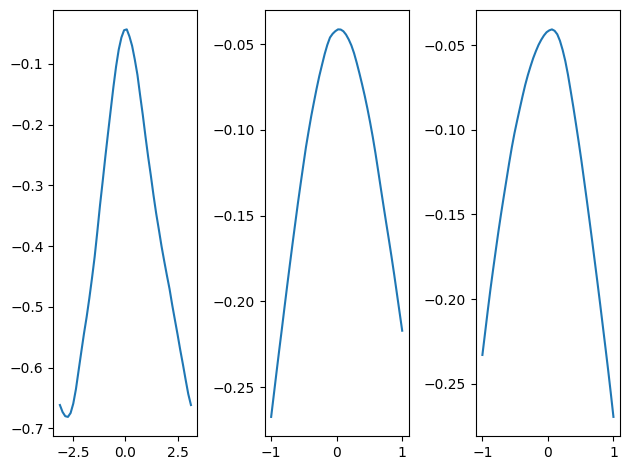

In [50]:
plot_rewards(nn_reward)

### Learning agent from learned reward

In [51]:
with open("./models/pendulum_nn_reward", "rb") as file:
    reward_net = pickle.load(file)

In [53]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

env = CustomNNRewardWrapper(env, reward_net)

In [54]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [55]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=50_000,
)

In [57]:
validation(env, actor, deterministic=True)

-482.3153615895659

MovieWriter imagemagick unavailable; using Pillow instead.


saving...


{'states': [array([-0.7039525,  0.7102471,  0.8182548], dtype=float32),
  array([-0.76011765,  0.64978546,  1.6509396 ], dtype=float32),
  array([-0.83349764,  0.552523  ,  2.438278  ], dtype=float32),
  array([-0.9098994 ,  0.41482893,  3.1526694 ], dtype=float32),
  array([-0.9714412 ,  0.23728031,  3.763791  ], dtype=float32),
  array([-0.9996225 ,  0.02747425,  4.2417507 ], dtype=float32),
  array([-0.9799392 , -0.19929665,  4.5623565 ], dtype=float32),
  array([-0.9063281 , -0.42257476,  4.7128835 ], dtype=float32),
  array([-0.78314936, -0.6218337 ,  4.6959524 ], dtype=float32),
  array([-0.6235188, -0.7818083,  4.5295773], dtype=float32),
  array([-0.44491065, -0.895575  ,  4.2432213 ], dtype=float32),
  array([-0.26431876, -0.9644354 ,  3.8715398 ], dtype=float32),
  array([-0.09496058, -0.995481  ,  3.4478722 ], dtype=float32),
  array([ 0.05491699, -0.9984909 ,  3.0009704 ], dtype=float32),
  array([ 0.18144138, -0.9834018 ,  2.5501468 ], dtype=float32),
  array([ 0.27551317,

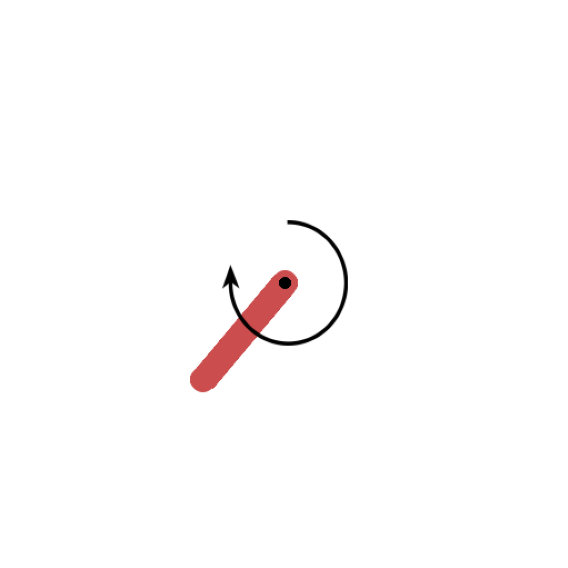

In [58]:
get_trajectory(env, actor, visualize=True)

## GAIL

In [197]:
class Discriminator(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [198]:
class DiscriminatorReward(nn.Module):
    def __init__(self, discriminator):
        super().__init__()
        self.discriminator = discriminator

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            rewards: (torch.Tensor): (B, 1)
        """
        reward = -torch.log(self.discriminator(observations, actions) + 1e-10)
        return reward

In [199]:
def gail_loss(
    discriminator,
    learning_trajectories,
    expert_trajectories,
):
    loss = {}

    learning_observations = learning_trajectories["observations"]
    learning_actions = learning_trajectories["actions"]

    learning_preds = discriminator(learning_observations, learning_actions)

    expert_observations = expert_trajectories["observations"]
    expert_actions = expert_trajectories["actions"]

    expert_preds = discriminator(expert_observations, expert_actions)

    loss["learning"] = -torch.log(learning_preds + 1e-10).mean()
    loss["expert"] = -torch.log(1 - expert_preds + 1e-10).mean()

    loss["discriminator"] = loss["expert"] + loss["learning"]

    return loss

In [202]:
def gail(
    env: gym.Env,
    expert_trajectories: dict[str, torch.Tensor],
    learning_actor: DeterministicMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    discriminator: RewardNet,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    discriminator_optimizer: Adam,
    total_episodes: int = 30,
):
    rollout_buffer = RolloutBuffer()

    reward_net = DiscriminatorReward(discriminator)
    env = CustomNNRewardWrapper(env, reward_net)

    logger = TensorBoardLogger(log_dir="./tb_logs/gail_")

    for episode_n in range(total_episodes):

        rollout_buffer.collect_rollouts(env, learning_actor, trajectories_n=50)
        learning_trajectories = rollout_buffer.get_data()

        loss = gail_loss(discriminator, learning_trajectories, expert_trajectories)

        loss["discriminator"].backward()
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

        reward_net = DiscriminatorReward(discriminator)
        env = CustomNNRewardWrapper(env, reward_net)

        sac(
            env,
            learning_actor,
            critic_1,
            critic_2,
            actor_optimizer,
            critic_1_optimizer,
            critic_2_optimizer,
            total_timesteps=5000,
        )

        # Logging
        logger.log_scalars(loss, episode_n)

In [203]:
learning_actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

discriminator = Discriminator(obs_dim, action_dim)

actor_optimizer = Adam(learning_actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

discriminator_optimizer = Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
gail(
    env,
    expert_trajectories,
    learning_actor,
    critic_1,
    critic_2,
    discriminator,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    discriminator_optimizer,
)

In [206]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

validation(env, learning_actor, deterministic=True)

-1371.772797565236

MovieWriter imagemagick unavailable; using Pillow instead.


saving...


{'states': [array([ 0.99937904, -0.03523489,  0.10718039], dtype=float32),
  array([ 0.9998687 , -0.01620376,  0.38075423], dtype=float32),
  array([0.9998519 , 0.01720988, 0.66830397], dtype=float32),
  array([0.9978049 , 0.06622279, 0.98121136], dtype=float32),
  array([0.99119395, 0.13241798, 1.3307348 ], dtype=float32),
  array([0.9760574 , 0.21751297, 1.7291535 ], dtype=float32),
  array([0.94640464, 0.32298338, 2.1922882 ], dtype=float32),
  array([0.89355624, 0.44895124, 2.7342234 ], dtype=float32),
  array([0.8055858, 0.5924791, 3.3708296], dtype=float32),
  array([0.6675433, 0.744571 , 4.1151824], dtype=float32),
  array([0.46375066, 0.88596576, 4.9736094 ], dtype=float32),
  array([0.18426083, 0.9828774 , 5.9380836 ], dtype=float32),
  array([-0.16271561,  0.986673  ,  6.9752417 ], dtype=float32),
  array([-0.5340996 ,  0.84542155,  8.        ], dtype=float32),
  array([-0.821161  ,  0.57069665,  8.        ], dtype=float32),
  array([-0.9785791,  0.2058713,  8.       ], dtype

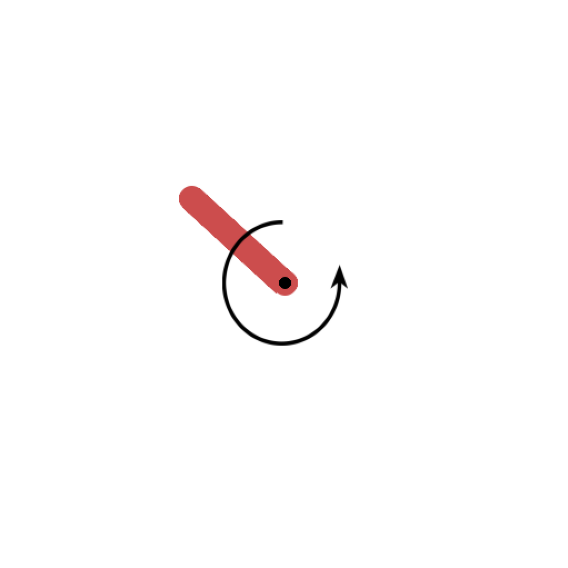

In [195]:
get_trajectory(env, actor, visualize=True)

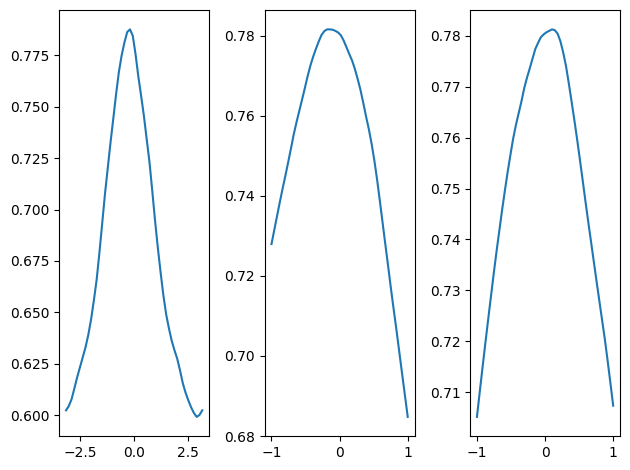

In [207]:
reward_net = DiscriminatorReward(discriminator)

plot_rewards(nn_reward)

## db

In [96]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [97]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


In [98]:
env.reset()

action = np.array([1]).reshape((action_dim,))
env.step(action)

(array([ 0.8564583 ,  0.5162162 , -0.13741326], dtype=float32),
 -0.3744487546671795,
 False,
 False,
 {})

In [99]:
reward_net = RewardNet(obs_dim, action_dim)
env = CustomNNRewardWrapper(env, reward_net)

In [106]:
env.reset()

action = np.array([1]).reshape((action_dim,))
env.step(action)

(array([-0.6536499 ,  0.7567971 ,  0.65377426], dtype=float32),
 -0.028410837054252625,
 False,
 False,
 {})

In [26]:
rb = RolloutBuffer()
actor = StochasticMlpPolicy(obs_dim, action_dim)

In [29]:
rb.collect_rollouts(env, actor, rollout_size=20)

In [31]:
data = rb.get_data()

In [32]:
print(
    data["observations"].shape,
    data["actions"].shape,
)

torch.Size([20, 3]) torch.Size([20, 1])


In [35]:
obs, _ = env.reset()

actions = []
for _ in range(10):
    action, _ = actor.predict(obs)
    print(action.shape)
    actions.append(action)
    next_obs, reward, term, trunc, _ = env.step(action)

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


In [38]:
actions = torch.tensor(actions)

In [40]:
actions.shape

torch.Size([10, 1])